# **DIVE INTO CODE COURSE**
## **Graduation Assignment**
**Student Name**: Doan Anh Tien<br>
**Student ID**: 1852789<br>
**Email**: tien.doan.g0pr0@hcmut.edu.vn

## Introduction

The graduation assignment was based on one of the challenges from the Vietnamese competition **Zalo AI Challenge**. The description of the challenge is described as follows:

> During the Covid-19 outbreak, the Vietnamese government pushed the "5K" public health safety message. In the message, masking and keeping a safe distance are two key rules that have been shown to be extremely successful in preventing people from contracting or spreading the virus. Enforcing these principles on a large scale is where technology may help. In this challenge, you will create algorithm to detect whether or not a person or group of individuals in a picture adhere to the "mask" and "distance" standards.

**Basic rules**
We are given the dataset contains images of people either wearing mask or not and they are standing either close of far from each other. Our mission is to predict whether the formation of these people adhere the 5k standard.

The 5k standard is also based on the two conditions, mask (0 == not wearing, 1 == wearing) and distancing (0 == too close, 1 == far enough). People that adhere the 5k standard will not likely to expose the virus to each other in case they did caught it before, and it is to prevent the spread of the COVID-19 pandamic through people interactions.



---



In [ ]:
import tensorflow as tf
tf.data.experimental.enable_debug_mode()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
#@title
!pip install cloud_tpu_client
from cloud_tpu_client import Client
c = Client(tpu='') # For TPU runtime
print(c.runtime_version())

In [ ]:
#@title
c.configure_tpu_version(tf.__version__, restart_type='ifNeeded')

In [ ]:
#@title
print(c.runtime_version())

In [ ]:
!nvidia-smi # For GPU runtime

/bin/bash: nvidia-smi: command not found


In [ ]:
# For when the TPU is used
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 22.1 MB/s 
     |████████████████████████████████| 180 kB 10.6 MB/s 
     |████████████████████████████████| 144 kB 46.1 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=801553c902342b547addea6197c927a54020bd95cf8bb1d44ced318953173edf
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation

/content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation


In [ ]:
!ls

assignment.ipynb  data


## **1. Resources preparation**

### Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import wandb
from wandb.keras import WandbCallback
from tensorflow.data import AUTOTUNE
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

# Some libraries will be imported later throughout the notebook

In [ ]:
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 2.8.0
Keras version: 2.8.0


### W&B login and init project

In [ ]:
!wandb login 88c91a7dc6dd5574f423e38f852c6fe640a7fcd0

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project="diveintocode-grad-1st-approach", entity="atien228")

wandb: Currently logged in as: atien228 (use `wandb login --relogin` to force relogin)


### Hyperparamaters

In [ ]:
standard = 'mask' #@param ['mask', 'distancing']
SEED = 42 #@param {type:'integer'}

wandb.config = {
  "learning_rate": 0.001, 
  "epochs": 15,
  "batch_size": 16,
  "momentum": 0.85,
  "smoothing": 0.1
}

### Preprocessing data-set 

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation/data'
img_dir = os.path.join(data_path, 'images')

os.listdir(img_dir)[:10]

['3180.jpg',
 '3200.jpg',
 '3204.jpg',
 '3193.jpg',
 '3184.jpg',
 '3181.jpg',
 '3183.jpg',
 '3178.jpg',
 '3186.jpg',
 '3179.jpg']

In [ ]:
meta = pd.read_csv(os.path.join(data_path, 'train_meta.csv'))
meta

,image_id,fname,mask,distancing,5k
0,1,1.jpg,1.0,1.0,1.0
1,2,2.jpg,0.0,NaN,NaN
2,3,3.jpg,1.0,1.0,1.0
3,4,4.jpg,1.0,1.0,1.0
4,5,5.jpg,0.0,0.0,0.0
...,...,...,...,...,...
4170,4171,4171.jpg,0.0,1.0,0.0
4171,4172,4172.jpg,1.0,1.0,1.0
4172,4173,4173.jpg,1.0,NaN,NaN
4173,4174,4174.jpg,1.0,1.0,1.0


In [ ]:
img1 = meta.iloc[0]

Image ID: 1, Mask: 1.0, Distancing: 1.0


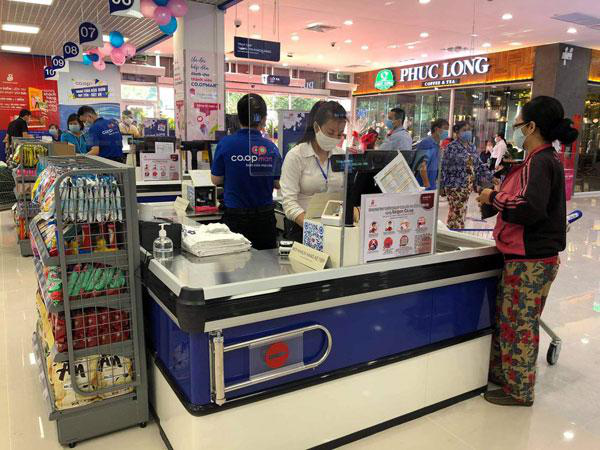

In [ ]:
print(r'Image ID: {}, Mask: {}, Distancing: {}'.format(img1['image_id'], img1['mask'], img1['distancing']))
img = Image.open(os.path.join(img_dir, img1['fname']))
img

In [ ]:
dataset = []
label = []

for idx, row in meta.iterrows():
  if pd.notna(row[standard]):
    dataset.append(os.path.join(img_dir, row['fname'])) # Mask or distancing
    label.append(row[standard])

for i in range(5):
  print(f'img: {dataset[i]} label: {label[i]}')

img: /content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation/data/images/1.jpg label: 1.0
img: /content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation/data/images/2.jpg label: 0.0
img: /content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation/data/images/3.jpg label: 1.0
img: /content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation/data/images/4.jpg label: 1.0
img: /content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation/data/images/5.jpg label: 0.0


In [ ]:
len(label_val)

689

Create a small portion of test set since the competition won't let me submit a new entry to check my score

In [ ]:
df_test = df_train[1200:1500]
label_test = label_train[1200:1500]

In [ ]:
df_train = df_train[:1200]
df_val = df_val[:300]
label_train = label_train[:1200]
label_val = label_val[:300]

In [ ]:
df_train[0]

'/content/drive/MyDrive/Colab Notebooks/DIVE INTO CODE/Graduation/data/images/3714.jpg'

In [ ]:
label_train[0]

1.0

In [ ]:
meta.iloc[3713]

image_id          3714
fname         3714.jpg
mask               1.0
distancing         0.0
5k                 0.0
Name: 3713, dtype: object

Create tuple of train and validation set for further process

In [ ]:
df_train = tuple(zip(df_train, label_train))
df_val = tuple(zip(df_val, label_val))

In [ ]:
df_train = tuple(zip(*df_train))
df_val = tuple(zip(*df_val))

### Tensorflow Hub for a variety of CNN models

EfficientNet models and ckpts (and other image classifer models too)

In [ ]:
import tensorflow_hub as hub

print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Hub version: 0.12.0
GPU is available


In [ ]:
def get_hub_url_and_isize(model_name):

  model_handle_map = {
    "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
    "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
    "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
    "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
    "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
    "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
    "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
    "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
    "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
    "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
    "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
    "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
    "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
    "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
    "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
    "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
    "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
    "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
    "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
    "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
    "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
    "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
    "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
    "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
    "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
    "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
    "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
    "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
    "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
    "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
    "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
    "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
    "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
    "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
    "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
    "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
    "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
    "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
    "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
    "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
    "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
    "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
    "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
    "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
    "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
    "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
    "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
    "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
  }

  model_image_size_map = {
    "efficientnetv2-s": 384,
    "efficientnetv2-m": 480,
    "efficientnetv2-l": 480,
    "efficientnetv2-b0": 224,
    "efficientnetv2-b1": 240,
    "efficientnetv2-b2": 260,
    "efficientnetv2-b3": 300,
    "efficientnetv2-s-21k": 384,
    "efficientnetv2-m-21k": 480,
    "efficientnetv2-l-21k": 480,
    "efficientnetv2-xl-21k": 512,
    "efficientnetv2-b0-21k": 224,
    "efficientnetv2-b1-21k": 240,
    "efficientnetv2-b2-21k": 260,
    "efficientnetv2-b3-21k": 300,
    "efficientnetv2-s-21k-ft1k": 384,
    "efficientnetv2-m-21k-ft1k": 480,
    "efficientnetv2-l-21k-ft1k": 480,
    "efficientnetv2-xl-21k-ft1k": 512,
    "efficientnetv2-b0-21k-ft1k": 224,
    "efficientnetv2-b1-21k-ft1k": 240,
    "efficientnetv2-b2-21k-ft1k": 260,
    "efficientnetv2-b3-21k-ft1k": 300, 
    "efficientnet_b0": 224,
    "efficientnet_b1": 240,
    "efficientnet_b2": 260,
    "efficientnet_b3": 300,
    "efficientnet_b4": 380,
    "efficientnet_b5": 456,
    "efficientnet_b6": 528,
    "efficientnet_b7": 600,
    "inception_v3": 299,
    "inception_resnet_v2": 299,
    "nasnet_large": 331,
    "pnasnet_large": 331,
  }

  model_type = model_handle_map.get(model_name)
  pixels = model_image_size_map.get(model_name)

  print(f"Selected model: {model_name} : {model_type}")

  IMAGE_SIZE = (pixels, pixels)
  print(f"Input size {IMAGE_SIZE}")

  return model_type, IMAGE_SIZE, pixels
  

In [ ]:
model_name = "efficientnetv2-b3-21k-ft1k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']
# num_epochs = 5 #@param {type: "integer"}
trainable = True #@param {type: "boolean"}
model_url, img_size, pixels = get_hub_url_and_isize(model_name)
IMG_HEIGHT = IMG_WIDTH = pixels

Selected model: efficientnetv2-b3-21k-ft1k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2
Input size (300, 300)


### Data-set interpretion

#### Load Image function for W&B

In [ ]:
def load_img(path, label):
   img = tf.io.read_file(path) # <= For non-TPU
  #  with open(path, "rb") as local_file: # <= For TPU
  #     img = local_file.read()
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
   onehot_label = tf.argmax(label == [0.0, 1.0])
  
  #  img = np.load(img.numpy(), allow_pickle=True)
  #  onehot_label = np.load(onehot_label.numpy(), allow_pickle=True)

   return img, onehot_label # ,img.shape(), onehot_label.shape()

#### Tensorflow Data-set

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((list(df_train[0]), list(df_train[1])))

# Configure with W&B settings
ds_train = (ds_train
            .shuffle(buffer_size=1024)
            .map(load_img, num_parallel_calls=AUTOTUNE)
            .batch(wandb.config['batch_size'])
            .cache()
            .prefetch(AUTOTUNE))

In [ ]:
ds_val = tf.data.Dataset.from_tensor_slices((list(df_val[0]), list(df_val[1])))

# Configure with W&B settings
ds_val = (ds_val
          .shuffle(buffer_size=1024)
          .map(load_img, num_parallel_calls=AUTOTUNE)
          .batch(wandb.config['batch_size'])
          .cache()
          .prefetch(AUTOTUNE))

In [ ]:
ds_train

<CacheDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## **2. Modeling**

### Define model structure and metrics

In [ ]:
from sklearn.metrics import f1_score
tf.config.run_functions_eagerly(True)
@tf.autograph.experimental.do_not_convert
def f1(y_true, y_pred):
    return f1_score(y_true,
                    tf.math.argmax(y_pred, 1))

In [ ]:
# Data augmentation layer for image
tf.keras.backend.clear_session()
# =============== TPU ==================

# with strategy.scope():
#     data_augmentation = tf.keras.Sequential([
#       keras.layers.InputLayer(input_shape=img_size + (3,)),
#       layers.RandomFlip("horizontal_and_vertical", seed=SEED),
#       layers.RandomRotation(0.2, seed=SEED),
#       layers.RandomZoom(0.1, seed=SEED)
#     ])

#     model = tf.keras.Sequential([
#       data_augmentation,
#       hub.KerasLayer(model_url, trainable=trainable), # Trainable: Fine tuning
#       layers.Dropout(rate=0.2, seed=SEED),
#       layers.Dense(units=2, # Binary classifcation
#                   activation='softmax')
#     ])

#     model.build((None,) + img_size + (3,)) # (IMG_SIZE, IMG_SIZE, 3)
#     model.summary()

#     # Update formula rule 
#     # velocity = momentum * velocity - learning_rate * g
#     # w = w + momentum * velocity - learning_rate * g

#     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=wandb.config['learning_rate'], momentum=wandb.config['momentum'], nesterov=True),
#                   #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=wandb.config['label_smoothing'])
#                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#                   metrics=['accuracy', f1])

# =============== GPU ==================

data_augmentation = tf.keras.Sequential([
      keras.layers.InputLayer(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]),
      layers.RandomFlip("horizontal_and_vertical", seed=SEED),
      # layers.RandomRotation(0.2, seed=SEED),
      layers.RandomZoom(0.1, seed=SEED),
      layers.experimental.preprocessing.RandomWidth(0.1, seed=SEED),
    ])

model = tf.keras.Sequential([
      data_augmentation,
      hub.KerasLayer(model_url, trainable=trainable), # Trainable: Fine tuning
      layers.Dropout(rate=0.2, seed=SEED),
      layers.Dense(units=2, # Binary classifcation
                    activation='softmax',
                    kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    ])


In [ ]:
model.build((None,) + img_size + (3,)) # (IMG_SIZE, IMG_SIZE, 3)
model.summary()

# Update formula rule (when nesterov=True)
# velocity = momentum * velocity - learning_rate * g
# w = w + momentum * velocity - learning_rate * g

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=wandb.config['learning_rate'], momentum=wandb.config['momentum'], nesterov=False),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=wandb.config['label_smoothing'])
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', f1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, None, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 12,933,696
Trainable params: 12,824,480
Non-trainable params: 109,216
_________________________________________________________________


### Train model with W&B monitoring

In [ ]:
hist = model.fit(ds_train, validation_data=ds_val,
                 epochs=wandb.config['epochs'],
                 callbacks=[WandbCallback()],
                 verbose=1).history

Epoch 1/15
75/75 [==============================] - 757s 10s/step - loss: 0.8605 - accuracy: 0.5800 - f1: 0.5849 - val_loss: 0.6581 - val_accuracy: 0.6533 - val_f1: 0.6981
Epoch 2/15
75/75 [==============================] - 134s 2s/step - loss: 0.6637 - accuracy: 0.6733 - f1: 0.6765 - val_loss: 0.6748 - val_accuracy: 0.6467 - val_f1: 0.7027
Epoch 3/15
75/75 [==============================] - 77s 1s/step - loss: 0.5724 - accuracy: 0.7267 - f1: 0.7378 - val_loss: 0.6526 - val_accuracy: 0.6733 - val_f1: 0.7152
Epoch 4/15
75/75 [==============================] - 93s 1s/step - loss: 0.5353 - accuracy: 0.7492 - f1: 0.7547 - val_loss: 0.6139 - val_accuracy: 0.7033 - val_f1: 0.7355
Epoch 5/15
75/75 [==============================] - 72s 954ms/step - loss: 0.4810 - accuracy: 0.7792 - f1: 0.7848 - val_loss: 0.5833 - val_accuracy: 0.7100 - val_f1: 0.7268
Epoch 6/15
75/75 [==============================] - 72s 959ms/step - loss: 0.4549 - accuracy: 0.7950 - f1: 0.8031 - val_loss: 0.5833 - val_accur

### Save model and weights

In [ ]:
model.save(data_path + f'/{standard}.keras')

In [ ]:
model.save_weights(
    data_path + f'/{standard}_weight.h5', overwrite=True, save_format=None, options=None
)

## **3. Evaluation**

### Self-made test dataset

We will evaluate the model performance with the small proportion of the test data-set that we have created

#### Mask detection

Predict trial for one image

In [ ]:
x_test = df_test[0] # Path to 655.jpg
y_test = label_test[0] # Mask label of 655.jpg

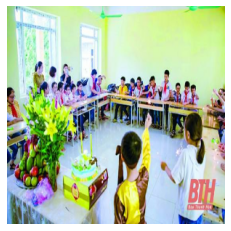

True label: No mask
Predicted label: No mask


In [ ]:
image = tf.io.read_file(x_test)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))

true_label = 'No mask' if (np.argmax(y_test) == 0) else 'Mask'

plt.imshow(image/255.0)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_label = 'No mask' if (np.argmax(prediction_scores) == 0) else 'Mask'

print("True label: " + true_label)
print("Predicted label: " + predicted_label)

Evaluate the test dataset

In [ ]:
from sklearn.metrics import accuracy_score

prediction_list = []

for i in range(len(df_test)):
  image = tf.io.read_file(df_test[i])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
  
  prediction_scores = model.predict(np.expand_dims(image, axis=0))
  prediction_list.append(np.argmax(prediction_scores))
  
  if (i % 10 == 0):
    print(f"Predicted {i} images.")

acc = accuracy_score(label_test, prediction_list)
print(f"Test accuracy: {acc}")

Predicted 0 images.
Predicted 10 images.
Predicted 20 images.
Predicted 30 images.
Predicted 40 images.
Predicted 50 images.
Predicted 60 images.
Predicted 70 images.
Predicted 80 images.
Predicted 90 images.
Predicted 100 images.
Predicted 110 images.
Predicted 120 images.
Predicted 130 images.
Predicted 140 images.
Predicted 150 images.
Predicted 160 images.
Predicted 170 images.
Predicted 180 images.
Predicted 190 images.
Predicted 200 images.
Predicted 210 images.
Predicted 220 images.
Predicted 230 images.
Predicted 240 images.
Predicted 250 images.
Predicted 260 images.
Predicted 270 images.
Predicted 280 images.
Predicted 290 images.
Test accuracy: 0.84


The test dataset was originally cut down from the train dataset and have not even interfere the training process of the model. So this accuracy is quite reasonable. Currently we have trained the model for detecting mask on people and predict whether they have adhered the 5K standards.

From here, we can change the `standard` variable from `'mask'` to `'distancing'` to train the second model that specifically serves for the distance detection purpose. After finished all requirements, we can use the results from both models to conclude the `5k attribute` and export the final submission.

The 5k attribute can be evaluated as the pseudo code below:
```
5k = 1 if (mask == 1 and distancing == 1) else 0
```

#### Distancing detection

Predict trial for one image

In [ ]:
x_test = df_test[10] # Path to 1995.jpg
y_test = label_test[10] # Mask label of 1995.jpg

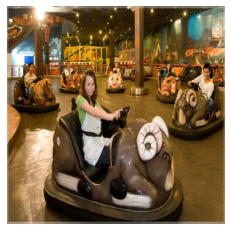

True label: Too close
Predicted label: Too close


In [ ]:
image = tf.io.read_file(x_test)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))

true_label = 'Too close' if (np.argmax(y_test) == 0) else 'Good distance'

plt.imshow(image/255.0)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_label = 'Too close' if (np.argmax(prediction_scores) == 0) else 'Good distance'

print("True label: " + true_label)
print("Predicted label: " + predicted_label)

Because there are many images missing either mask, distancing or 5k labels (even all of them), the model cannot determine so well and hence the accuracy is reduced.

Evaluate the test dataset

In [ ]:
from sklearn.metrics import accuracy_score

prediction_list = []

for i in range(len(df_test)):
  image = tf.io.read_file(df_test[i])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
  
  prediction_scores = model.predict(np.expand_dims(image, axis=0))
  prediction_list.append(np.argmax(prediction_scores))
  
  if (i % 10 == 0):
    print(f"Predicted {i} images.")

acc = accuracy_score(label_test, prediction_list)
print(f"Test accuracy: {acc}")

Predicted 0 images.
Predicted 10 images.
Predicted 20 images.
Predicted 30 images.
Predicted 40 images.
Predicted 50 images.
Predicted 60 images.
Predicted 70 images.
Predicted 80 images.
Predicted 90 images.
Predicted 100 images.
Predicted 110 images.
Predicted 120 images.
Predicted 130 images.
Predicted 140 images.
Predicted 150 images.
Predicted 160 images.
Predicted 170 images.
Predicted 180 images.
Predicted 190 images.
Predicted 200 images.
Predicted 210 images.
Predicted 220 images.
Predicted 230 images.
Predicted 240 images.
Predicted 250 images.
Predicted 260 images.
Predicted 270 images.
Predicted 280 images.
Predicted 290 images.
Test accuracy: 0.7166666666666667


Apparently, the **dataset** is missing a lot of distancing attribute compared to the **mask**. As said, the accuracy for detecting the distance is quite lower than the model of mask detection.


### Public Test set

In [ ]:
meta_test = pd.read_csv(data_path + '/test/public_test_meta.csv')
df_public_test = meta_test['fname']
test_img_path = data_path + '/test/images/'

#### Mask prediction

Load Model

In [ ]:
dependencies = {
    'f1': f1,
    'KerasLayer': hub.KerasLayer(model_url, trainable=trainable)
}
model_mask = keras.models.load_model(data_path + f'/{standard}.keras', custom_objects=dependencies)

Predict

In [ ]:
def predict_public_test(model, img_path):

  prediction_list = []

  for i, row in enumerate(df_public_test):
    image = tf.io.read_file(img_path + row)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    prediction_list.append(np.argmax(prediction_scores))
    
    if (i % 10 == 0):
      print(f"Predicted {i} images.")

  return prediction_list

In [ ]:
# Mask prediction
prediction_mask_list = predict_public_test(model_mask, test_img_path)

Predicted 0 images.
Predicted 10 images.
Predicted 20 images.
Predicted 30 images.
Predicted 40 images.
Predicted 50 images.
Predicted 60 images.
Predicted 70 images.
Predicted 80 images.
Predicted 90 images.
Predicted 100 images.
Predicted 110 images.
Predicted 120 images.
Predicted 130 images.
Predicted 140 images.
Predicted 150 images.
Predicted 160 images.
Predicted 170 images.
Predicted 180 images.
Predicted 190 images.
Predicted 200 images.
Predicted 210 images.
Predicted 220 images.
Predicted 230 images.
Predicted 240 images.
Predicted 250 images.
Predicted 260 images.
Predicted 270 images.
Predicted 280 images.
Predicted 290 images.
Predicted 300 images.
Predicted 310 images.
Predicted 320 images.
Predicted 330 images.
Predicted 340 images.
Predicted 350 images.
Predicted 360 images.
Predicted 370 images.
Predicted 380 images.
Predicted 390 images.
Predicted 400 images.
Predicted 410 images.
Predicted 420 images.
Predicted 430 images.
Predicted 440 images.
Predicted 450 images.

#### Distancing prediction

In [ ]:
# Switch standards
standard = 'distancing' #@param ['mask', 'distancing']

Load model

In [ ]:
dependencies = {
    'f1': f1,
    'KerasLayer': hub.KerasLayer(model_url, trainable=trainable)
}
model_distancing = keras.models.load_model(data_path + f'/{standard}.keras', custom_objects=dependencies)

Predict

In [ ]:
# Distancing prediction
prediction_distancing_list = predict_public_test(model_distancing, test_img_path)

Predicted 0 images.
Predicted 10 images.
Predicted 20 images.
Predicted 30 images.
Predicted 40 images.
Predicted 50 images.
Predicted 60 images.
Predicted 70 images.
Predicted 80 images.
Predicted 90 images.
Predicted 100 images.
Predicted 110 images.
Predicted 120 images.
Predicted 130 images.
Predicted 140 images.
Predicted 150 images.
Predicted 160 images.
Predicted 170 images.
Predicted 180 images.
Predicted 190 images.
Predicted 200 images.
Predicted 210 images.
Predicted 220 images.
Predicted 230 images.
Predicted 240 images.
Predicted 250 images.
Predicted 260 images.
Predicted 270 images.
Predicted 280 images.
Predicted 290 images.
Predicted 300 images.
Predicted 310 images.
Predicted 320 images.
Predicted 330 images.
Predicted 340 images.
Predicted 350 images.
Predicted 360 images.
Predicted 370 images.
Predicted 380 images.
Predicted 390 images.
Predicted 400 images.
Predicted 410 images.
Predicted 420 images.
Predicted 430 images.
Predicted 440 images.
Predicted 450 images.

In [ ]:
meta_test_results = meta_test.copy()
meta_test['5k'] = [1 if prediction_mask_list[i] == 1 and prediction_distancing_list[i] == 1 else 0 for i in range(len(meta_test))]

In [ ]:
meta_test_results[:10]

,image_id,fname,5k
0,1,1.jpg,0
1,2,2.jpg,1
2,3,3.jpg,1
3,4,4.jpg,1
4,5,5.jpg,0
5,6,6.jpg,1
6,7,7.jpg,1
7,8,8.jpg,1
8,9,9.jpg,0
9,10,10.jpg,1


In [ ]:
import os
os.makedirs(data_path + '/submission', exist_ok=True)  
meta_test_results.to_csv(data_path + '/submission/5k-compliance-submission.csv')

## **4. Recreate the pipeline**

Since making the process of detecting mask and distancing to be seperated procedures, evaluate new models or changing hyperparameters would be exhausted. In this section, I manage to create the pipeline that can be run once to train, predict and monitor the metrics. 

But before heading to that part, we can re-examine our problem to find a better way for a better results. One problem still remains is that the dataset contain so many missing values, and it is in fact can affect our model predictions, hence getting less accuracy.

Missing values

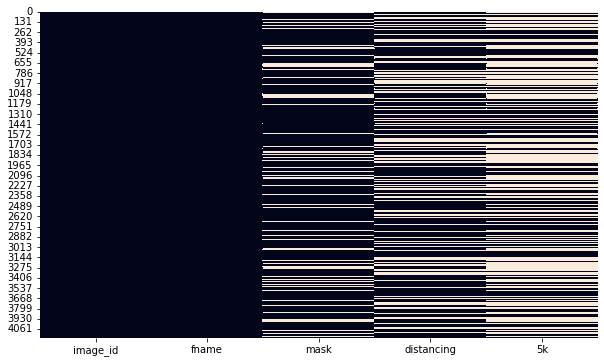

In [ ]:
#@title
plt.figure(figsize=(10,6))
sns.heatmap(meta.isnull(), cbar=False)

In [ ]:
#@title
print('Num. missing mask',\
      len(meta[meta['mask'].isna()]))

print('Num. missing distancing',\
      len(meta[meta['distancing'].isna()]))

print('Num. missing 5k',\
      len(meta[meta['5k'].isna()]))

print('Num. missing mask and distancing:',\
      len(meta[(meta['mask'].isna()) & (meta['distancing'].isna())]))

print('Num. missing mask and 5k:',\
      len(meta[(meta['mask'].isna()) & (meta['5k'].isna())]))

print('Num. missing distancing and 5k:',\
      len(meta[(meta['distancing'].isna()) & (meta['5k'].isna())]))

print('Num. missing all three attributes:',\
      len(meta[(meta['mask'].isna()) & (meta['distancing'].isna()) & (meta['5k'].isna())]))

Num. missing mask 734
Num. missing distancing 1273
Num. missing 5k 2007
Num. missing mask and distancing: 0
Num. missing mask and 5k: 734
Num. missing distancing and 5k: 1273
Num. missing all three attributes: 0


Apparently, the missing values are occurs as either missing one of three attribute, or a pair of attributes respectively (except for mask and distancing). None of row missing all three attributes.

To get the 5k value, we should have know the mask and distancing value first. Luckily, none of row miss these two variables. Therefore, we can fill the missing values with our own logics (not all the cases).

The original rule for 5k evaluation can be described as follow:
```
5k = 1 if (mask == 1 and distancing == 1) else 0
```

Base on this, we can design a pipeline that can fill out the missing values and produce better results:

> 1. Model mask detection -> Use to predict the missing mask values -> From there continue to fill the missing distancing values
```
if (mask == 1) and (5k == 1):
    distancing = 1
elif (mask == 1) and (5k == 0):
    distancing = 0
elif (mask == 0) and (5k == 0)
    distancing = 0
```
In case the mask is 0, we can skip it since `mask == 0 and 5k == 0` is the only case we can intepret with and in that case, I have run the code: 
`meta[(meta['mask'] == 0) & (meta['5k'] == 0) & (meta['distancing'].isna())]` and it return nothing. So it is safe to assume this part does not miss any values and is skippable.

> 2. Model distancing -> Use to predict the missing 5k values
```
if (distancing == 1) and (mask == 1)
    5k == 1
elif (distancing == 0) or (mask == 0)
    5k == 0
```

> 3. Model 5k -> Use to predict the final output 5k

In conclusion, the difference between the previous section and this section is that we will make three models instead of two. This is doable as we are going to fill the missing 5k values, thus we can use this attribute for our final prediction. For the new approach, please switch to `new_approach_kaggle.ipynb`

**Note 1**: After having a bad experience with Google Colab, I have switched the later approach to Kaggle with a longer session period and stronger GPU. But since Kaggle does not adapt the data storage/data retrieval well as Google Drive, I did had some trouble during using it. Thus some of the output files will need to download onto my PC in order to save the progress.

**Note 2**: The approach and procedures applied in this notebook is the initial one that I come up with first. In summary, I trained two models of mask detection and distancing detection. And after having the model trained, they will predict the `mask` and `distancing` labels. Based on the mask and distancing label, I use conditions to get the final label 5k. This approach is heavily unreliable since I skip all the missing values here.

For the new approach, I trained the mask model to predict the original train data-set again and fill all missing mask values. Then I used the updated data-set to continue to train the distance model and predict again to fill all missing distance values. After this step, I use the conditions again to fill the missing 5k values. In final step, I train the 5k model in order to predict the 5k label, which is differ from the initial approach where I did not use the 5k label for the train and evaluation process but instead generate it immediately based on the mask and distancing labels.

Comparing these two approaches, I personally think that the later one is better since it rely on all of the data. For example, having the results based on the mask and distancing only is not a good way since errors can occur in either predictions. Therefore, if we want to have 5k results for submission, we should train the model based on 5k values as well. And to make it happen, we should have investigate and interpret the missing values too.

